In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# Step 1: Load your data with low_memory=False
final_combined_data_path = r"D:\MSc AI\Envance\final_combined_data.csv"  # Update with your file path
final_combined_data = pd.read_csv(final_combined_data_path, low_memory=False)

# Step 2: Use a smaller sample of the data for quicker testing (e.g., 10% of the data)
sampled_data = final_combined_data.sample(frac=0.1, random_state=42)

# Step 3: Re-create bng_summary with the sampled data
first_years = sampled_data.groupby('Group')['Year'].min().reset_index()
last_years = sampled_data.groupby('Group')['Year'].max().reset_index()

bng_data = sampled_data.merge(first_years, on="Group", suffixes=('', '_First'))
bng_data = bng_data.merge(last_years, on="Group", suffixes=('', '_Last'))

initial_occupancy = bng_data[bng_data['Year'] == bng_data['Year_First']][['Group', 'Mean']].rename(columns={'Mean': 'Initial_Occupancy'})
final_occupancy = bng_data[bng_data['Year'] == bng_data['Year_Last']][['Group', 'Mean']].rename(columns={'Mean': 'Final_Occupancy'})

bng_summary = initial_occupancy.merge(final_occupancy, on='Group')
bng_summary['Net_Gain'] = bng_summary['Final_Occupancy'] - bng_summary['Initial_Occupancy']

# Step 4: Data Preparation
# One-hot encode the 'Group' categorical variable
encoder = OneHotEncoder(sparse_output=False)
group_encoded = encoder.fit_transform(bng_summary[['Group']])
group_encoded_df = pd.DataFrame(group_encoded, columns=encoder.get_feature_names_out(['Group']))

# Combine the encoded group data with the original data
bng_ml_data = pd.concat([bng_summary, group_encoded_df], axis=1)
bng_ml_data = bng_ml_data.drop(columns=['Group'])

# Step 5: Split the data into training and testing sets
X = bng_ml_data.drop(columns=['Net_Gain'])
y = bng_ml_data['Net_Gain']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 6: Train a Random Forest Regressor with fewer estimators
model = RandomForestRegressor(n_estimators=10, random_state=42)
model.fit(X_train, y_train)

# Step 7: Make predictions and evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

# Step 8: Feature Importance
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print(importance_df)


Mean Absolute Error (MAE): 0.0003391802881704897
R² Score: 0.9999948837433362
                          Feature    Importance
1                 Final_Occupancy  5.017322e-01
0               Initial_Occupancy  4.982630e-01
20                    Group_Moths  1.106822e-06
17                  Group_Lichens  7.585712e-07
5                Group_Bryophytes  5.304237e-07
31                  Group_Weevils  3.976374e-07
12              Group_FungusGnats  3.514746e-07
28                  Group_Spiders  3.127390e-07
23                Group_PlantBugs  2.643938e-07
4                      Group_Bees  1.960163e-07
30                    Group_Wasps  1.197893e-07
11  Group_Empid&DolichopodidFlies  1.138129e-07
14               Group_Hoverflies  9.798200e-08
9                Group_Craneflies  9.184040e-08
7                  Group_Carabids  8.036661e-08
24              Group_RoveBeetles  6.950849e-08
21        Group_NonmarineMolluscs  5.668137e-08
27             Group_Soldierflies  4.277341e-08
13        

In [2]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor

# Step 1: Gradient Boosting Regressor
print("Gradient Boosting Regressor:")
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)
print(f"Mean Absolute Error (MAE): {mae_gbr}")
print(f"R² Score: {r2_gbr}")

# Step 2: XGBoost Regressor
print("\nXGBoost Regressor:")
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"R² Score: {r2_xgb}")


Gradient Boosting Regressor:
Mean Absolute Error (MAE): 0.006401433684114199
R² Score: 0.9991666294940651

XGBoost Regressor:
Mean Absolute Error (MAE): 0.0030737337491243523
R² Score: 0.9998012273195963


In [3]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
from sklearn.model_selection import GridSearchCV

# Step 1: Model Validation Using K-Fold Cross-Validation
print("Model Validation Using K-Fold Cross-Validation:")

# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=kf, scoring='r2')
print(f"XGBoost Cross-Validation R² Scores: {xgb_cv_scores}")
print(f"Mean R² Score: {np.mean(xgb_cv_scores)}")

# Step 2: Feature Importance Analysis for XGBoost
print("\nFeature Importance Analysis:")
importances = xgb_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(importance_df)

# Step 3: Hyperparameter Tuning for XGBoost
print("\nHyperparameter Tuning for XGBoost:")
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Setting up Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='r2', cv=kf, verbose=2)
grid_search.fit(X, y)

# Best parameters from the Grid Search
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best R² Score from Grid Search: {grid_search.best_score_}")



Model Validation Using K-Fold Cross-Validation:
XGBoost Cross-Validation R² Scores: [0.99979955 0.99979779 0.99980577 0.99980296 0.99979921]
Mean R² Score: 0.9998010543924554

Feature Importance Analysis:
                          Feature  Importance
1                 Final_Occupancy    0.499725
0               Initial_Occupancy    0.498028
31                  Group_Weevils    0.000319
27             Group_Soldierflies    0.000294
11  Group_Empid&DolichopodidFlies    0.000285
17                  Group_Lichens    0.000165
23                Group_PlantBugs    0.000157
14               Group_Hoverflies    0.000137
9                Group_Craneflies    0.000106
28                  Group_Spiders    0.000094
18                 Group_Mayflies    0.000086
5                Group_Bryophytes    0.000073
20                    Group_Moths    0.000073
21        Group_NonmarineMolluscs    0.000072
12              Group_FungusGnats    0.000071
24              Group_RoveBeetles    0.000069
7            

In [4]:
# Save bng_summary to a CSV file
bng_summary.to_csv('bng_summary.csv', index=False)
print("bng_summary data has been saved to 'bng_summary.csv'")


bng_summary data has been saved to 'bng_summary.csv'


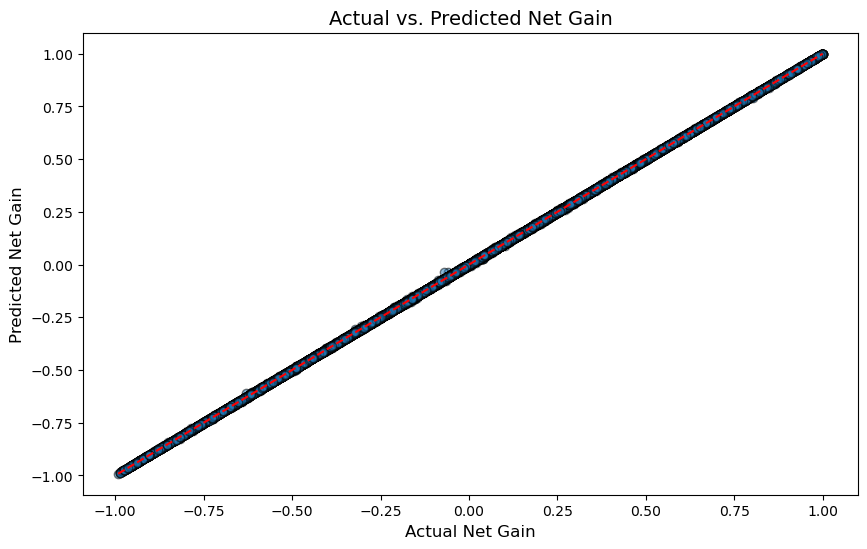

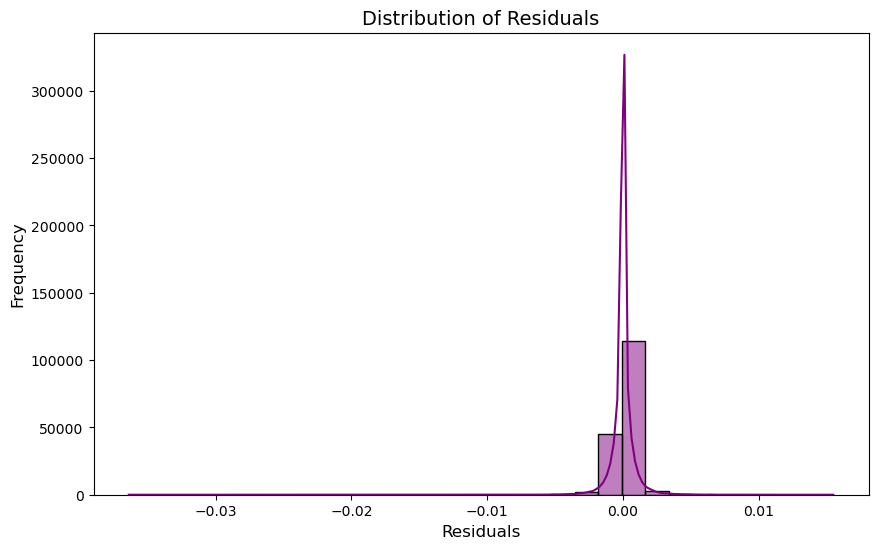

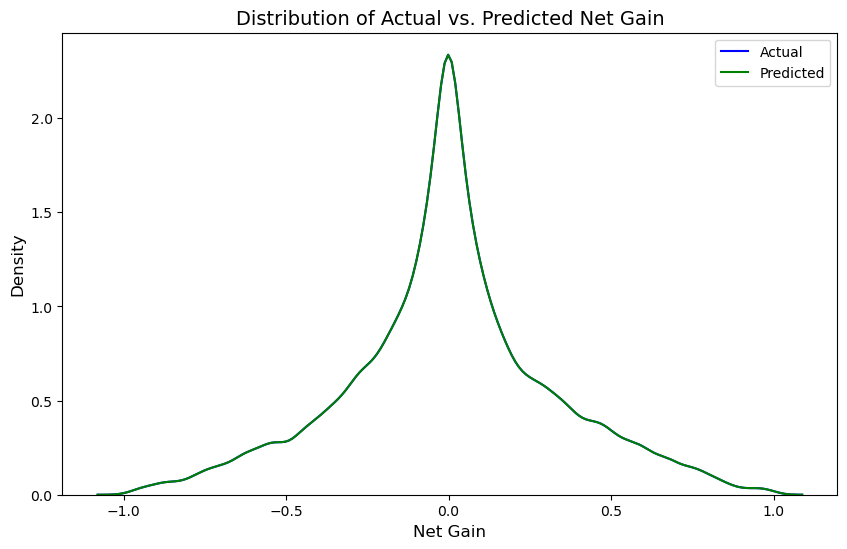

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Scatter Plot of Actual vs. Predicted Net Gain
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolor='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Net Gain", fontsize=12)
plt.ylabel("Predicted Net Gain", fontsize=12)
plt.title("Actual vs. Predicted Net Gain", fontsize=14)
plt.show()

# Step 2: Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Residuals", fontsize=14)
plt.show()

# Step 3: Distribution Plot of Actual vs. Predicted
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label="Actual", color='blue')
sns.kdeplot(y_pred, label="Predicted", color='green')
plt.xlabel("Net Gain", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distribution of Actual vs. Predicted Net Gain", fontsize=14)
plt.legend()
plt.show()
